In [2]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::349934754982:role/service-role/AmazonSageMaker-ExecutionRole-20190918T150782
CPU times: user 2.35 s, sys: 2.24 s, total: 4.59 s
Wall time: 1.02 s


In [3]:
s3_bucket = 'my-dl-models'
s3_prefix = 'DEMO-ObjectDetection-birds'

In [1]:
import gluoncv as gcv
from gluoncv.data import VOCDetection
# typically we use 2007+2012 trainval splits for training data
train_dataset = VOCDetection(splits=[(2007, 'trainval'), (2012, 'trainval')])
# and use 2007 test as validation data
val_dataset = VOCDetection(splits=[(2007, 'test')])

print('Training images:', len(train_dataset))
print('Validation images:', len(val_dataset))

Training images: 16551
Validation images: 4952


In [ ]:
train_dataset

In [2]:
train_image, train_label = train_dataset[60]
bboxes = train_label[:, :4]
cids = train_label[:, 4:5]
print('image:', train_image.shape)
print('bboxes:', bboxes.shape, 'class ids:', cids.shape)

image: (500, 334, 3)
bboxes: (6, 4) class ids: (6, 1)


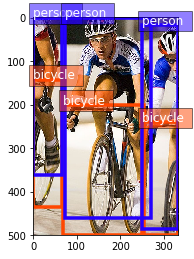

In [3]:
from matplotlib import pyplot as plt
from gluoncv.utils import viz

ax = viz.plot_bbox(train_image.asnumpy(), bboxes, labels=cids, class_names=train_dataset.classes)
plt.show()

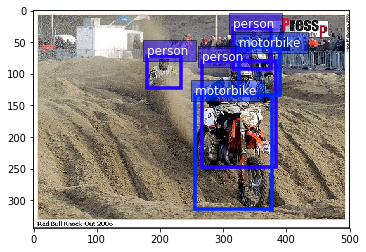

In [4]:
val_image, val_label = val_dataset[100]
bboxes = val_label[:, :4]
cids = val_label[:, 4:5]
ax = viz.plot_bbox(val_image.asnumpy(), bboxes, labels=cids, class_names=train_dataset.classes)
plt.show()

In [7]:
!mkdir data/train data/test

In [19]:
with open("data/train/hello.txt", "w") as f:   # Opens file and casts as f 
    f.write("Hello World form " + f.name)       # Writing
    # File closed automatically

In [20]:
with open("data/test/hello.txt", "w") as f:   # Opens file and casts as f 
    f.write("Hello World form " + f.name)       # Writing
    # File closed automatically

In [3]:
traindata_s3_prefix = '{}/data/train'.format(s3_prefix)
testdata_s3_prefix = '{}/data/test'.format(s3_prefix)
output_s3 = 's3://{}/{}/models/'.format(s3_bucket, s3_prefix)
code_location_s3 = 's3://{}/{}/codes'.format(s3_bucket, s3_prefix)

In [3]:
train_s3 = sess.upload_data(path='./data/train/', bucket=s3_bucket, key_prefix=traindata_s3_prefix)
test_s3 = sess.upload_data(path='./data/test/', bucket=s3_bucket, key_prefix=testdata_s3_prefix)


NameError: name 'traindata_s3_prefix' is not defined

In [4]:
train_s3='s3://{}/{}/train/'.format(s3_bucket, s3_prefix)
validation_s3='s3://{}/{}/validation/'.format(s3_bucket, s3_prefix)
output_s3 = 's3://{}/{}/models/'.format(s3_bucket, s3_prefix)

In [5]:
output_s3

's3://my-dl-models/DEMO-ObjectDetection-birds/models/'

In [6]:
inputs = {'train':train_s3, 'test': validation_s3}

print(inputs)

{'train': 's3://my-dl-models/DEMO-ObjectDetection-birds/train/', 'test': 's3://my-dl-models/DEMO-ObjectDetection-birds/validation/'}


In [7]:
import sagemaker
from sagemaker.mxnet import MXNet
import os

In [8]:
hyperparameters = {'epochs': 200}

In [9]:
mxnet_estimator = MXNet(entry_point='yolo_train4.py',
                       source_dir='./src',
                        role=role,
                        train_instance_type='ml.p3.16xlarge',
                        train_instance_count=1,
                        framework_version='1.4.1',
                        py_version='py3',
                        hyperparameters=hyperparameters,
                        metric_definitions=[{'Name': 'validation:MeanAP', 'Regex': 'Validation: VOCMeanAP=(.*?) ;'},
                                           {'Name': 'train:MeanAP', 'Regex': 'Train: VOCMeanAP=(.*?) ;'}],
                        output_path=output_s3,
                        base_job_name='yolov3-birds'
                       )
mxnet_estimator.fit(inputs)

2019-10-09 01:10:05 Starting - Starting the training job...
2019-10-09 01:10:06 Starting - Launching requested ML instances.........
2019-10-09 01:12:05 Starting - Preparing the instances for training.........
2019-10-09 01:13:22 Downloading - Downloading input data
2019-10-09 01:13:22 Training - Downloading the training image...
2019-10-09 01:13:48 Training - Training image download completed. Training in progress.2019-10-09 01:13:49,013 sagemaker-containers INFO     Imported framework sagemaker_mxnet_container.training
2019-10-09 01:13:49,096 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{"epochs":200}', 'SM_USER_ENTRY_POINT': 'yolo_train4.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_host":"algo-1","hosts":["algo-1"],"network_interface_name":"eth0"}', 'SM_INPUT_DATA_CONFIG': '{"test":{"RecordWrapperType":"None","S3DistributionType":"FullyReplicated","TrainingInpu

#015  0%|          | 0/224190 [00:00<?, ?KB/s]#015  0%|          | 94/224190 [00:00<06:19, 590.52KB/s]#015  0%|          | 522/224190 [00:00<04:50, 771.26KB/s]#015  1%|          | 2042/224190 [00:00<03:26, 1078.35KB/s]#015  2%|▏         | 4198/224190 [00:00<02:25, 1508.17KB/s]#015  3%|▎         | 7305/224190 [00:00<01:42, 2110.60KB/s]#015  6%|▌         | 12607/224190 [00:00<01:11, 2964.55KB/s]#015  8%|▊         | 17978/224190 [00:00<00:49, 4137.16KB/s]#015 10%|█         | 23426/224190 [00:00<00:35, 5723.91KB/s]#015 13%|█▎        | 28690/224190 [00:01<00:25, 7812.89KB/s]#015 16%|█▌        | 35101/224190 [00:01<00:17, 10607.16KB/s]#015 19%|█▊        | 41547/224190 [00:01<00:12, 14154.83KB/s]#015 21%|██▏       | 48049/224190 [00:01<00:09, 18495.19KB/s]#015 24%|██▍       | 54562/224190 [00:01<00:07, 23554.16KB/s]#015 27%|██▋       | 61115/224190 [00:01<00:05, 29156.79KB/s]#015 30%|███       | 67673/224190 [00:01<00:04, 34985.17KB/s]#015 33%|███▎      | 74266/224190 [00:01<00:03, 40717.76KB

epoch  3 , batch  0
epoch  3 , batch  1
epoch  3 , batch  2
epoch  3 , batch  3
epoch  3 , batch  4
epoch  3 , batch  5
epoch  3 , batch  6
epoch  3 , batch  7
epoch  3 , batch  8
epoch  3 , batch  9
epoch  3 , batch  10
epoch  3 , batch  11
epoch  3 , batch  12
epoch  3 , batch  13
epoch  3 , batch  14
epoch  3 , batch  15
epoch  3 , batch  16
epoch  3 , batch  17
epoch  3 , batch  18
epoch  3 , batch  19
epoch  3 , batch  20
epoch  3 , batch  21
epoch  3 , batch  22
epoch  3 , batch  23
epoch  3 , batch  24
epoch  3 , batch  25
epoch  3 , batch  26
epoch  3 , batch  27
epoch  3 , batch  28
epoch  3 , batch  29
epoch  3 , batch  30
epoch  3 , batch  31
epoch  3 , batch  32
epoch  3 , batch  33
epoch  3 , batch  34
epoch  3 , batch  35
epoch  3 , batch  36
epoch  3 , batch  37
INFO:root:[Epoch 3] Training cost: 12.602, ObjLoss=3.984, BoxCenterLoss=2.094, BoxScaleLoss=0.993, ClassLoss=2.952
validate: 4
MAP PRINTINNNNNNGGGG
INFO:root:[Epoch 3] Validation: VOCMeanAP=0.08816289500119708 ;


epoch  9 , batch  22
epoch  9 , batch  23
epoch  9 , batch  24
epoch  9 , batch  25
epoch  9 , batch  26
epoch  9 , batch  27
epoch  9 , batch  28
epoch  9 , batch  29
epoch  9 , batch  30
epoch  9 , batch  31
epoch  9 , batch  32
epoch  9 , batch  33
epoch  9 , batch  34
epoch  9 , batch  35
epoch  9 , batch  36
epoch  9 , batch  37
INFO:root:[Epoch 9] Training cost: 10.281, ObjLoss=3.402, BoxCenterLoss=2.036, BoxScaleLoss=1.027, ClassLoss=2.235
validate: 10
MAP PRINTINNNNNNGGGG
INFO:root:[Epoch 9] Validation: VOCMeanAP=0.7306253974433887 ;
epoch  10 , batch  0
epoch  10 , batch  1
epoch  10 , batch  2
epoch  10 , batch  3
epoch  10 , batch  4
epoch  10 , batch  5
epoch  10 , batch  6
epoch  10 , batch  7
epoch  10 , batch  8
epoch  10 , batch  9
epoch  10 , batch  10
epoch  10 , batch  11
epoch  10 , batch  12
epoch  10 , batch  13
epoch  10 , batch  14
epoch  10 , batch  15
epoch  10 , batch  16
epoch  10 , batch  17
epoch  10 , batch  18
epoch  10 , batch  19
epoch  10 , batch  20


epoch  15 , batch  25
epoch  15 , batch  26
epoch  15 , batch  27
epoch  15 , batch  28
epoch  15 , batch  29
epoch  15 , batch  30
epoch  15 , batch  31
epoch  15 , batch  32
epoch  15 , batch  33
epoch  15 , batch  34
epoch  15 , batch  35
epoch  15 , batch  36
epoch  15 , batch  37
INFO:root:[Epoch 15] Training cost: 13.184, ObjLoss=3.132, BoxCenterLoss=2.008, BoxScaleLoss=0.993, ClassLoss=1.876
validate: 16
MAP PRINTINNNNNNGGGG
INFO:root:[Epoch 15] Validation: VOCMeanAP=0.6688935147927296 ;
epoch  16 , batch  0
epoch  16 , batch  1
epoch  16 , batch  2
epoch  16 , batch  3
epoch  16 , batch  4
epoch  16 , batch  5
epoch  16 , batch  6
epoch  16 , batch  7
epoch  16 , batch  8
epoch  16 , batch  9
epoch  16 , batch  10
epoch  16 , batch  11
epoch  16 , batch  12
epoch  16 , batch  13
epoch  16 , batch  14
epoch  16 , batch  15
epoch  16 , batch  16
epoch  16 , batch  17
epoch  16 , batch  18
epoch  16 , batch  19
epoch  16 , batch  20
epoch  16 , batch  21
epoch  16 , batch  22
epoc

epoch  21 , batch  36
epoch  21 , batch  37
validate: 22
INFO:root:[Epoch 21] Training cost: 12.106, ObjLoss=2.926, BoxCenterLoss=1.985, BoxScaleLoss=0.945, ClassLoss=1.646
MAP PRINTINNNNNNGGGG
INFO:root:[Epoch 21] Validation: VOCMeanAP=0.7811109514441259 ;
epoch  22 , batch  0
epoch  22 , batch  1
epoch  22 , batch  2
epoch  22 , batch  3
epoch  22 , batch  4
epoch  22 , batch  5
epoch  22 , batch  6
epoch  22 , batch  7
epoch  22 , batch  8
epoch  22 , batch  9
epoch  22 , batch  10
epoch  22 , batch  11
epoch  22 , batch  12
epoch  22 , batch  13
epoch  22 , batch  14
epoch  22 , batch  15
epoch  22 , batch  16
epoch  22 , batch  17
epoch  22 , batch  18
epoch  22 , batch  19
epoch  22 , batch  20
epoch  22 , batch  21
epoch  22 , batch  22
epoch  22 , batch  23
epoch  22 , batch  24
epoch  22 , batch  25
epoch  22 , batch  26
epoch  22 , batch  27
epoch  22 , batch  28
epoch  22 , batch  29
epoch  22 , batch  30
epoch  22 , batch  31
epoch  22 , batch  32
epoch  22 , batch  33
epoc

MAP PRINTINNNNNNGGGG
INFO:root:[Epoch 27] Validation: VOCMeanAP=0.8885779910858961 ;
epoch  28 , batch  0
epoch  28 , batch  1
epoch  28 , batch  2
epoch  28 , batch  3
epoch  28 , batch  4
epoch  28 , batch  5
epoch  28 , batch  6
epoch  28 , batch  7
epoch  28 , batch  8
epoch  28 , batch  9
epoch  28 , batch  10
epoch  28 , batch  11
epoch  28 , batch  12
epoch  28 , batch  13
epoch  28 , batch  14
epoch  28 , batch  15
epoch  28 , batch  16
epoch  28 , batch  17
epoch  28 , batch  18
epoch  28 , batch  19
epoch  28 , batch  20
epoch  28 , batch  21
epoch  28 , batch  22
epoch  28 , batch  23
epoch  28 , batch  24
epoch  28 , batch  25
epoch  28 , batch  26
epoch  28 , batch  27
epoch  28 , batch  28
epoch  28 , batch  29
epoch  28 , batch  30
epoch  28 , batch  31
epoch  28 , batch  32
epoch  28 , batch  33
epoch  28 , batch  34
epoch  28 , batch  35
epoch  28 , batch  36
INFO:root:[Epoch 28] Training cost: 13.391, ObjLoss=2.706, BoxCenterLoss=1.968, BoxScaleLoss=0.826, ClassLoss=1

epoch  34 , batch  18
epoch  34 , batch  19
epoch  34 , batch  20
epoch  34 , batch  21
epoch  34 , batch  22
epoch  34 , batch  23
epoch  34 , batch  24
epoch  34 , batch  25
epoch  34 , batch  26
epoch  34 , batch  27
epoch  34 , batch  28
epoch  34 , batch  29
epoch  34 , batch  30
epoch  34 , batch  31
epoch  34 , batch  32
epoch  34 , batch  33
epoch  34 , batch  34
epoch  34 , batch  35
epoch  34 , batch  36
INFO:root:[Epoch 34] Training cost: 12.825, ObjLoss=2.546, BoxCenterLoss=1.962, BoxScaleLoss=0.753, ClassLoss=1.349
validate: 35
MAP PRINTINNNNNNGGGG
INFO:root:[Epoch 34] Validation: VOCMeanAP=0.8882443304467789 ;
epoch  35 , batch  0
epoch  35 , batch  1
epoch  35 , batch  2
epoch  35 , batch  3
epoch  35 , batch  4
epoch  35 , batch  5
epoch  35 , batch  6
epoch  35 , batch  7
epoch  35 , batch  8
epoch  35 , batch  9
epoch  35 , batch  10
epoch  35 , batch  11
epoch  35 , batch  12
epoch  35 , batch  13
epoch  35 , batch  14
epoch  35 , batch  15
epoch  35 , batch  16
epoc

epoch  40 , batch  27
epoch  40 , batch  28
epoch  40 , batch  29
epoch  40 , batch  30
epoch  40 , batch  31
epoch  40 , batch  32
epoch  40 , batch  33
epoch  40 , batch  34
epoch  40 , batch  35
epoch  40 , batch  36
INFO:root:[Epoch 40] Training cost: 12.963, ObjLoss=2.415, BoxCenterLoss=1.952, BoxScaleLoss=0.697, ClassLoss=1.260
validate: 41
MAP PRINTINNNNNNGGGG
INFO:root:[Epoch 40] Validation: VOCMeanAP=0.91505507459797 ;
epoch  41 , batch  0
epoch  41 , batch  1
epoch  41 , batch  2
epoch  41 , batch  3
epoch  41 , batch  4
epoch  41 , batch  5
epoch  41 , batch  6
epoch  41 , batch  7
epoch  41 , batch  8
epoch  41 , batch  9
epoch  41 , batch  10
epoch  41 , batch  11
epoch  41 , batch  12
epoch  41 , batch  13
epoch  41 , batch  14
epoch  41 , batch  15
epoch  41 , batch  16
epoch  41 , batch  17
epoch  41 , batch  18
epoch  41 , batch  19
epoch  41 , batch  20
epoch  41 , batch  21
epoch  41 , batch  22
epoch  41 , batch  23
epoch  41 , batch  24
epoch  41 , batch  25
epoch 

MAP PRINTINNNNNNGGGG
INFO:root:[Epoch 46] Validation: VOCMeanAP=0.9225057007121243 ;
epoch  47 , batch  0
epoch  47 , batch  1
epoch  47 , batch  2
epoch  47 , batch  3
epoch  47 , batch  4
epoch  47 , batch  5
epoch  47 , batch  6
epoch  47 , batch  7
epoch  47 , batch  8
epoch  47 , batch  9
epoch  47 , batch  10
epoch  47 , batch  11
epoch  47 , batch  12
epoch  47 , batch  13
epoch  47 , batch  14
epoch  47 , batch  15
epoch  47 , batch  16
epoch  47 , batch  17
epoch  47 , batch  18
epoch  47 , batch  19
epoch  47 , batch  20
epoch  47 , batch  21
epoch  47 , batch  22
epoch  47 , batch  23
epoch  47 , batch  24
epoch  47 , batch  25
epoch  47 , batch  26
epoch  47 , batch  27
epoch  47 , batch  28
epoch  47 , batch  29
epoch  47 , batch  30
epoch  47 , batch  31
epoch  47 , batch  32
epoch  47 , batch  33
epoch  47 , batch  34
epoch  47 , batch  35
epoch  47 , batch  36
epoch  47 , batch  37
INFO:root:[Epoch 47] Training cost: 13.483, ObjLoss=2.306, BoxCenterLoss=1.946, BoxScaleL

MAP PRINTINNNNNNGGGG
INFO:root:[Epoch 52] Validation: VOCMeanAP=0.925623510115585 ;
epoch  53 , batch  0
epoch  53 , batch  1
epoch  53 , batch  2
epoch  53 , batch  3
epoch  53 , batch  4
epoch  53 , batch  5
epoch  53 , batch  6
epoch  53 , batch  7
epoch  53 , batch  8
epoch  53 , batch  9
epoch  53 , batch  10
epoch  53 , batch  11
epoch  53 , batch  12
epoch  53 , batch  13
epoch  53 , batch  14
epoch  53 , batch  15
epoch  53 , batch  16
epoch  53 , batch  17
epoch  53 , batch  18
epoch  53 , batch  19
epoch  53 , batch  20
epoch  53 , batch  21
epoch  53 , batch  22
epoch  53 , batch  23
epoch  53 , batch  24
epoch  53 , batch  25
epoch  53 , batch  26
epoch  53 , batch  27
epoch  53 , batch  28
epoch  53 , batch  29
epoch  53 , batch  30
epoch  53 , batch  31
epoch  53 , batch  32
epoch  53 , batch  33
epoch  53 , batch  34
epoch  53 , batch  35
epoch  53 , batch  36
epoch  53 , batch  37
INFO:root:[Epoch 53] Training cost: 10.593, ObjLoss=2.233, BoxCenterLoss=1.944, BoxScaleLo

epoch  59 , batch  7
epoch  59 , batch  8
epoch  59 , batch  9
epoch  59 , batch  10
epoch  59 , batch  11
epoch  59 , batch  12
epoch  59 , batch  13
epoch  59 , batch  14
epoch  59 , batch  15
epoch  59 , batch  16
epoch  59 , batch  17
epoch  59 , batch  18
epoch  59 , batch  19
epoch  59 , batch  20
epoch  59 , batch  21
epoch  59 , batch  22
epoch  59 , batch  23
epoch  59 , batch  24
epoch  59 , batch  25
epoch  59 , batch  26
epoch  59 , batch  27
epoch  59 , batch  28
epoch  59 , batch  29
epoch  59 , batch  30
epoch  59 , batch  31
epoch  59 , batch  32
epoch  59 , batch  33
epoch  59 , batch  34
epoch  59 , batch  35
epoch  59 , batch  36
epoch  59 , batch  37
INFO:root:[Epoch 59] Training cost: 12.243, ObjLoss=2.148, BoxCenterLoss=1.938, BoxScaleLoss=0.587, ClassLoss=1.080
validate: 60
MAP PRINTINNNNNNGGGG
INFO:root:[Epoch 59] Validation: VOCMeanAP=0.9333012928013197 ;
epoch  60 , batch  0
epoch  60 , batch  1
epoch  60 , batch  2
epoch  60 , batch  3
epoch  60 , batch  4
ep

epoch  65 , batch  2
epoch  65 , batch  3
epoch  65 , batch  4
epoch  65 , batch  5
epoch  65 , batch  6
epoch  65 , batch  7
epoch  65 , batch  8
epoch  65 , batch  9
epoch  65 , batch  10
epoch  65 , batch  11
epoch  65 , batch  12
epoch  65 , batch  13
epoch  65 , batch  14
epoch  65 , batch  15
epoch  65 , batch  16
epoch  65 , batch  17
epoch  65 , batch  18
epoch  65 , batch  19
epoch  65 , batch  20
epoch  65 , batch  21
epoch  65 , batch  22
epoch  65 , batch  23
epoch  65 , batch  24
epoch  65 , batch  25
epoch  65 , batch  26
epoch  65 , batch  27
epoch  65 , batch  28
epoch  65 , batch  29
epoch  65 , batch  30
epoch  65 , batch  31
epoch  65 , batch  32
epoch  65 , batch  33
epoch  65 , batch  34
epoch  65 , batch  35
epoch  65 , batch  36
epoch  65 , batch  37
INFO:root:[Epoch 65] Training cost: 13.518, ObjLoss=2.091, BoxCenterLoss=1.931, BoxScaleLoss=0.563, ClassLoss=1.044
validate: 66
MAP PRINTINNNNNNGGGG
INFO:root:[Epoch 65] Validation: VOCMeanAP=0.9388683425326839 ;
ep

MAP PRINTINNNNNNGGGG
INFO:root:[Epoch 70] Validation: VOCMeanAP=0.9332111139990443 ;
epoch  71 , batch  0
epoch  71 , batch  1
epoch  71 , batch  2
epoch  71 , batch  3
epoch  71 , batch  4
epoch  71 , batch  5
epoch  71 , batch  6
epoch  71 , batch  7
epoch  71 , batch  8
epoch  71 , batch  9
epoch  71 , batch  10
epoch  71 , batch  11
epoch  71 , batch  12
epoch  71 , batch  13
epoch  71 , batch  14
epoch  71 , batch  15
epoch  71 , batch  16
epoch  71 , batch  17
epoch  71 , batch  18
epoch  71 , batch  19
epoch  71 , batch  20
epoch  71 , batch  21
epoch  71 , batch  22
epoch  71 , batch  23
epoch  71 , batch  24
epoch  71 , batch  25
epoch  71 , batch  26
epoch  71 , batch  27
epoch  71 , batch  28
epoch  71 , batch  29
epoch  71 , batch  30
epoch  71 , batch  31
epoch  71 , batch  32
epoch  71 , batch  33
epoch  71 , batch  34
epoch  71 , batch  35
epoch  71 , batch  36
epoch  71 , batch  37
INFO:root:[Epoch 71] Training cost: 11.296, ObjLoss=2.035, BoxCenterLoss=1.926, BoxScaleL

epoch  76 , batch  36
INFO:root:[Epoch 76] Training cost: 11.218, ObjLoss=1.983, BoxCenterLoss=1.923, BoxScaleLoss=0.527, ClassLoss=0.989
validate: 77
MAP PRINTINNNNNNGGGG
INFO:root:[Epoch 76] Validation: VOCMeanAP=0.9353768094409807 ;
epoch  77 , batch  0
epoch  77 , batch  1
epoch  77 , batch  2
epoch  77 , batch  3
epoch  77 , batch  4
epoch  77 , batch  5
epoch  77 , batch  6
epoch  77 , batch  7
epoch  77 , batch  8
epoch  77 , batch  9
epoch  77 , batch  10
epoch  77 , batch  11
epoch  77 , batch  12
epoch  77 , batch  13
epoch  77 , batch  14
epoch  77 , batch  15
epoch  77 , batch  16
epoch  77 , batch  17
epoch  77 , batch  18
epoch  77 , batch  19
epoch  77 , batch  20
epoch  77 , batch  21
epoch  77 , batch  22
epoch  77 , batch  23
epoch  77 , batch  24
epoch  77 , batch  25
epoch  77 , batch  26
epoch  77 , batch  27
epoch  77 , batch  28
epoch  77 , batch  29
epoch  77 , batch  30
epoch  77 , batch  31
epoch  77 , batch  32
epoch  77 , batch  33
epoch  77 , batch  34
epoc

epoch  83 , batch  3
epoch  83 , batch  4
epoch  83 , batch  5
epoch  83 , batch  6
epoch  83 , batch  7
epoch  83 , batch  8
epoch  83 , batch  9
epoch  83 , batch  10
epoch  83 , batch  11
epoch  83 , batch  12
epoch  83 , batch  13
epoch  83 , batch  14
epoch  83 , batch  15
epoch  83 , batch  16
epoch  83 , batch  17
epoch  83 , batch  18
epoch  83 , batch  19
epoch  83 , batch  20
epoch  83 , batch  21
epoch  83 , batch  22
epoch  83 , batch  23
epoch  83 , batch  24
epoch  83 , batch  25
epoch  83 , batch  26
epoch  83 , batch  27
epoch  83 , batch  28
epoch  83 , batch  29
epoch  83 , batch  30
epoch  83 , batch  31
epoch  83 , batch  32
epoch  83 , batch  33
epoch  83 , batch  34
epoch  83 , batch  35
epoch  83 , batch  36
epoch  83 , batch  37
INFO:root:[Epoch 83] Training cost: 12.386, ObjLoss=1.925, BoxCenterLoss=1.919, BoxScaleLoss=0.508, ClassLoss=0.955
validate: 84
MAP PRINTINNNNNNGGGG
INFO:root:[Epoch 83] Validation: VOCMeanAP=0.9451711653319126 ;
epoch  84 , batch  0
ep

epoch  89 , batch  4
epoch  89 , batch  5
epoch  89 , batch  6
epoch  89 , batch  7
epoch  89 , batch  8
epoch  89 , batch  9
epoch  89 , batch  10
epoch  89 , batch  11
epoch  89 , batch  12
epoch  89 , batch  13
epoch  89 , batch  14
epoch  89 , batch  15
epoch  89 , batch  16
epoch  89 , batch  17
epoch  89 , batch  18
epoch  89 , batch  19
epoch  89 , batch  20
epoch  89 , batch  21
epoch  89 , batch  22
epoch  89 , batch  23
epoch  89 , batch  24
epoch  89 , batch  25
epoch  89 , batch  26
epoch  89 , batch  27
epoch  89 , batch  28
epoch  89 , batch  29
epoch  89 , batch  30
epoch  89 , batch  31
epoch  89 , batch  32
epoch  89 , batch  33
epoch  89 , batch  34
epoch  89 , batch  35
epoch  89 , batch  36
epoch  89 , batch  37
INFO:root:[Epoch 89] Training cost: 13.422, ObjLoss=1.877, BoxCenterLoss=1.915, BoxScaleLoss=0.493, ClassLoss=0.925
validate: 90
MAP PRINTINNNNNNGGGG
INFO:root:[Epoch 89] Validation: VOCMeanAP=0.9430846012569039 ;
epoch  90 , batch  0
epoch  90 , batch  1
ep

epoch  95 , batch  2
epoch  95 , batch  3
epoch  95 , batch  4
epoch  95 , batch  5
epoch  95 , batch  6
epoch  95 , batch  7
epoch  95 , batch  8
epoch  95 , batch  9
epoch  95 , batch  10
epoch  95 , batch  11
epoch  95 , batch  12
epoch  95 , batch  13
epoch  95 , batch  14
epoch  95 , batch  15
epoch  95 , batch  16
epoch  95 , batch  17
epoch  95 , batch  18
epoch  95 , batch  19
epoch  95 , batch  20
epoch  95 , batch  21
epoch  95 , batch  22
epoch  95 , batch  23
epoch  95 , batch  24
epoch  95 , batch  25
epoch  95 , batch  26
epoch  95 , batch  27
epoch  95 , batch  28
epoch  95 , batch  29
epoch  95 , batch  30
epoch  95 , batch  31
epoch  95 , batch  32
epoch  95 , batch  33
epoch  95 , batch  34
epoch  95 , batch  35
epoch  95 , batch  36
epoch  95 , batch  37
INFO:root:[Epoch 95] Training cost: 12.932, ObjLoss=1.836, BoxCenterLoss=1.912, BoxScaleLoss=0.479, ClassLoss=0.899
validate: 96
MAP PRINTINNNNNNGGGG
INFO:root:[Epoch 95] Validation: VOCMeanAP=0.9475471115557322 ;
ep

epoch  101 , batch  16
epoch  101 , batch  17
epoch  101 , batch  18
epoch  101 , batch  19
epoch  101 , batch  20
epoch  101 , batch  21
epoch  101 , batch  22
epoch  101 , batch  23
epoch  101 , batch  24
epoch  101 , batch  25
epoch  101 , batch  26
epoch  101 , batch  27
epoch  101 , batch  28
epoch  101 , batch  29
epoch  101 , batch  30
epoch  101 , batch  31
epoch  101 , batch  32
epoch  101 , batch  33
epoch  101 , batch  34
epoch  101 , batch  35
epoch  101 , batch  36
epoch  101 , batch  37
validate: 102
INFO:root:[Epoch 101] Training cost: 12.967, ObjLoss=1.792, BoxCenterLoss=1.910, BoxScaleLoss=0.468, ClassLoss=0.874
MAP PRINTINNNNNNGGGG
INFO:root:[Epoch 101] Validation: VOCMeanAP=0.9411288228782968 ;
epoch  102 , batch  0
epoch  102 , batch  1
epoch  102 , batch  2
epoch  102 , batch  3
epoch  102 , batch  4
epoch  102 , batch  5
epoch  102 , batch  6
epoch  102 , batch  7
epoch  102 , batch  8
epoch  102 , batch  9
epoch  102 , batch  10
epoch  102 , batch  11
epoch  102 

epoch  107 , batch  27
epoch  107 , batch  28
epoch  107 , batch  29
epoch  107 , batch  30
epoch  107 , batch  31
epoch  107 , batch  32
epoch  107 , batch  33
epoch  107 , batch  34
epoch  107 , batch  35
epoch  107 , batch  36
epoch  107 , batch  37
INFO:root:[Epoch 107] Training cost: 12.756, ObjLoss=1.756, BoxCenterLoss=1.907, BoxScaleLoss=0.457, ClassLoss=0.853
validate: 108
MAP PRINTINNNNNNGGGG
INFO:root:[Epoch 107] Validation: VOCMeanAP=0.9460434181427217 ;
epoch  108 , batch  0
epoch  108 , batch  1
epoch  108 , batch  2
epoch  108 , batch  3
epoch  108 , batch  4
epoch  108 , batch  5
epoch  108 , batch  6
epoch  108 , batch  7
epoch  108 , batch  8
epoch  108 , batch  9
epoch  108 , batch  10
epoch  108 , batch  11
epoch  108 , batch  12
epoch  108 , batch  13
epoch  108 , batch  14
epoch  108 , batch  15
epoch  108 , batch  16
epoch  108 , batch  17
epoch  108 , batch  18
epoch  108 , batch  19
epoch  108 , batch  20
epoch  108 , batch  21
epoch  108 , batch  22
epoch  108 

epoch  113 , batch  27
epoch  113 , batch  28
epoch  113 , batch  29
epoch  113 , batch  30
epoch  113 , batch  31
epoch  113 , batch  32
epoch  113 , batch  33
epoch  113 , batch  34
epoch  113 , batch  35
epoch  113 , batch  36
epoch  113 , batch  37
INFO:root:[Epoch 113] Training cost: 12.756, ObjLoss=1.722, BoxCenterLoss=1.905, BoxScaleLoss=0.447, ClassLoss=0.833
validate: 114
MAP PRINTINNNNNNGGGG
INFO:root:[Epoch 113] Validation: VOCMeanAP=0.9395314320598015 ;
epoch  114 , batch  0
epoch  114 , batch  1
epoch  114 , batch  2
epoch  114 , batch  3
epoch  114 , batch  4
epoch  114 , batch  5
epoch  114 , batch  6
epoch  114 , batch  7
epoch  114 , batch  8
epoch  114 , batch  9
epoch  114 , batch  10
epoch  114 , batch  11
epoch  114 , batch  12
epoch  114 , batch  13
epoch  114 , batch  14
epoch  114 , batch  15
epoch  114 , batch  16
epoch  114 , batch  17
epoch  114 , batch  18
epoch  114 , batch  19
epoch  114 , batch  20
epoch  114 , batch  21
epoch  114 , batch  22
epoch  114 

epoch  119 , batch  16
epoch  119 , batch  17
epoch  119 , batch  18
epoch  119 , batch  19
epoch  119 , batch  20
epoch  119 , batch  21
epoch  119 , batch  22
epoch  119 , batch  23
epoch  119 , batch  24
epoch  119 , batch  25
epoch  119 , batch  26
epoch  119 , batch  27
epoch  119 , batch  28
epoch  119 , batch  29
epoch  119 , batch  30
epoch  119 , batch  31
epoch  119 , batch  32
epoch  119 , batch  33
epoch  119 , batch  34
epoch  119 , batch  35
epoch  119 , batch  36
epoch  119 , batch  37
INFO:root:[Epoch 119] Training cost: 10.770, ObjLoss=1.684, BoxCenterLoss=1.902, BoxScaleLoss=0.438, ClassLoss=0.815
validate: 120
MAP PRINTINNNNNNGGGG
INFO:root:[Epoch 119] Validation: VOCMeanAP=0.9511147966025367 ;
epoch  120 , batch  0
epoch  120 , batch  1
epoch  120 , batch  2
epoch  120 , batch  3
epoch  120 , batch  4
epoch  120 , batch  5
epoch  120 , batch  6
epoch  120 , batch  7
epoch  120 , batch  8
epoch  120 , batch  9
epoch  120 , batch  10
epoch  120 , batch  11
epoch  120 

epoch  125 , batch  4
epoch  125 , batch  5
epoch  125 , batch  6
epoch  125 , batch  7
epoch  125 , batch  8
epoch  125 , batch  9
epoch  125 , batch  10
epoch  125 , batch  11
epoch  125 , batch  12
epoch  125 , batch  13
epoch  125 , batch  14
epoch  125 , batch  15
epoch  125 , batch  16
epoch  125 , batch  17
epoch  125 , batch  18
epoch  125 , batch  19
epoch  125 , batch  20
epoch  125 , batch  21
epoch  125 , batch  22
epoch  125 , batch  23
epoch  125 , batch  24
epoch  125 , batch  25
epoch  125 , batch  26
epoch  125 , batch  27
epoch  125 , batch  28
epoch  125 , batch  29
epoch  125 , batch  30
epoch  125 , batch  31
epoch  125 , batch  32
epoch  125 , batch  33
epoch  125 , batch  34
epoch  125 , batch  35
epoch  125 , batch  36
epoch  125 , batch  37
INFO:root:[Epoch 125] Training cost: 13.595, ObjLoss=1.654, BoxCenterLoss=1.899, BoxScaleLoss=0.429, ClassLoss=0.797
validate: 126
MAP PRINTINNNNNNGGGG
INFO:root:[Epoch 125] Validation: VOCMeanAP=0.935871388539274 ;
epoch  1

epoch  131 , batch  4
epoch  131 , batch  5
epoch  131 , batch  6
epoch  131 , batch  7
epoch  131 , batch  8
epoch  131 , batch  9
epoch  131 , batch  10
epoch  131 , batch  11
epoch  131 , batch  12
epoch  131 , batch  13
epoch  131 , batch  14
epoch  131 , batch  15
epoch  131 , batch  16
epoch  131 , batch  17
epoch  131 , batch  18
epoch  131 , batch  19
epoch  131 , batch  20
epoch  131 , batch  21
epoch  131 , batch  22
epoch  131 , batch  23
epoch  131 , batch  24
epoch  131 , batch  25
epoch  131 , batch  26
epoch  131 , batch  27
epoch  131 , batch  28
epoch  131 , batch  29
epoch  131 , batch  30
epoch  131 , batch  31
epoch  131 , batch  32
epoch  131 , batch  33
epoch  131 , batch  34
epoch  131 , batch  35
epoch  131 , batch  36
epoch  131 , batch  37
INFO:root:[Epoch 131] Training cost: 11.104, ObjLoss=1.625, BoxCenterLoss=1.896, BoxScaleLoss=0.421, ClassLoss=0.782
validate: 132
MAP PRINTINNNNNNGGGG
INFO:root:[Epoch 131] Validation: VOCMeanAP=0.9263183429531695 ;
epoch  

epoch  136 , batch  35
epoch  136 , batch  36
INFO:root:[Epoch 136] Training cost: 10.365, ObjLoss=1.603, BoxCenterLoss=1.895, BoxScaleLoss=0.415, ClassLoss=0.770
validate: 137
MAP PRINTINNNNNNGGGG
INFO:root:[Epoch 136] Validation: VOCMeanAP=0.9535190195300046 ;
epoch  137 , batch  0
epoch  137 , batch  1
epoch  137 , batch  2
epoch  137 , batch  3
epoch  137 , batch  4
epoch  137 , batch  5
epoch  137 , batch  6
epoch  137 , batch  7
epoch  137 , batch  8
epoch  137 , batch  9
epoch  137 , batch  10
epoch  137 , batch  11
epoch  137 , batch  12
epoch  137 , batch  13
epoch  137 , batch  14
epoch  137 , batch  15
epoch  137 , batch  16
epoch  137 , batch  17
epoch  137 , batch  18
epoch  137 , batch  19
epoch  137 , batch  20
epoch  137 , batch  21
epoch  137 , batch  22
epoch  137 , batch  23
epoch  137 , batch  24
epoch  137 , batch  25
epoch  137 , batch  26
epoch  137 , batch  27
epoch  137 , batch  28
epoch  137 , batch  29
epoch  137 , batch  30
epoch  137 , batch  31
epoch  137 

epoch  143 , batch  7
epoch  143 , batch  8
epoch  143 , batch  9
epoch  143 , batch  10
epoch  143 , batch  11
epoch  143 , batch  12
epoch  143 , batch  13
epoch  143 , batch  14
epoch  143 , batch  15
epoch  143 , batch  16
epoch  143 , batch  17
epoch  143 , batch  18
epoch  143 , batch  19
epoch  143 , batch  20
epoch  143 , batch  21
epoch  143 , batch  22
epoch  143 , batch  23
epoch  143 , batch  24
epoch  143 , batch  25
epoch  143 , batch  26
epoch  143 , batch  27
epoch  143 , batch  28
epoch  143 , batch  29
epoch  143 , batch  30
epoch  143 , batch  31
epoch  143 , batch  32
epoch  143 , batch  33
epoch  143 , batch  34
epoch  143 , batch  35
epoch  143 , batch  36
epoch  143 , batch  37
INFO:root:[Epoch 143] Training cost: 11.717, ObjLoss=1.574, BoxCenterLoss=1.893, BoxScaleLoss=0.407, ClassLoss=0.754
validate: 144
MAP PRINTINNNNNNGGGG
INFO:root:[Epoch 143] Validation: VOCMeanAP=0.943740702484336 ;
epoch  144 , batch  0
epoch  144 , batch  1
epoch  144 , batch  2
epoch  1

epoch  149 , batch  14
epoch  149 , batch  15
epoch  149 , batch  16
epoch  149 , batch  17
epoch  149 , batch  18
epoch  149 , batch  19
epoch  149 , batch  20
epoch  149 , batch  21
epoch  149 , batch  22
epoch  149 , batch  23
epoch  149 , batch  24
epoch  149 , batch  25
epoch  149 , batch  26
epoch  149 , batch  27
epoch  149 , batch  28
epoch  149 , batch  29
epoch  149 , batch  30
epoch  149 , batch  31
epoch  149 , batch  32
epoch  149 , batch  33
epoch  149 , batch  34
epoch  149 , batch  35
epoch  149 , batch  36
epoch  149 , batch  37
INFO:root:[Epoch 149] Training cost: 11.815, ObjLoss=1.550, BoxCenterLoss=1.891, BoxScaleLoss=0.401, ClassLoss=0.741
validate: 150
MAP PRINTINNNNNNGGGG
INFO:root:[Epoch 149] Validation: VOCMeanAP=0.9550301004246974 ;
epoch  150 , batch  0
epoch  150 , batch  1
epoch  150 , batch  2
epoch  150 , batch  3
epoch  150 , batch  4
epoch  150 , batch  5
epoch  150 , batch  6
epoch  150 , batch  7
epoch  150 , batch  8
epoch  150 , batch  9
epoch  150 

epoch  155 , batch  14
epoch  155 , batch  15
epoch  155 , batch  16
epoch  155 , batch  17
epoch  155 , batch  18
epoch  155 , batch  19
epoch  155 , batch  20
epoch  155 , batch  21
epoch  155 , batch  22
epoch  155 , batch  23
epoch  155 , batch  24
epoch  155 , batch  25
epoch  155 , batch  26
epoch  155 , batch  27
epoch  155 , batch  28
epoch  155 , batch  29
epoch  155 , batch  30
epoch  155 , batch  31
epoch  155 , batch  32
epoch  155 , batch  33
epoch  155 , batch  34
epoch  155 , batch  35
epoch  155 , batch  36
epoch  155 , batch  37
INFO:root:[Epoch 155] Training cost: 12.556, ObjLoss=1.525, BoxCenterLoss=1.889, BoxScaleLoss=0.395, ClassLoss=0.728
validate: 156
MAP PRINTINNNNNNGGGG
INFO:root:[Epoch 155] Validation: VOCMeanAP=0.9589588688593496 ;
epoch  156 , batch  0
epoch  156 , batch  1
epoch  156 , batch  2
epoch  156 , batch  3
epoch  156 , batch  4
epoch  156 , batch  5
epoch  156 , batch  6
epoch  156 , batch  7
epoch  156 , batch  8
epoch  156 , batch  9
epoch  156 

epoch  161 , batch  1
epoch  161 , batch  2
epoch  161 , batch  3
epoch  161 , batch  4
epoch  161 , batch  5
epoch  161 , batch  6
epoch  161 , batch  7
epoch  161 , batch  8
epoch  161 , batch  9
epoch  161 , batch  10
epoch  161 , batch  11
epoch  161 , batch  12
epoch  161 , batch  13
epoch  161 , batch  14
epoch  161 , batch  15
epoch  161 , batch  16
epoch  161 , batch  17
epoch  161 , batch  18
epoch  161 , batch  19
epoch  161 , batch  20
epoch  161 , batch  21
epoch  161 , batch  22
epoch  161 , batch  23
epoch  161 , batch  24
epoch  161 , batch  25
epoch  161 , batch  26
epoch  161 , batch  27
epoch  161 , batch  28
epoch  161 , batch  29
epoch  161 , batch  30
epoch  161 , batch  31
epoch  161 , batch  32
epoch  161 , batch  33
epoch  161 , batch  34
epoch  161 , batch  35
epoch  161 , batch  36
epoch  161 , batch  37
INFO:root:[Epoch 161] Training cost: 10.433, ObjLoss=1.504, BoxCenterLoss=1.887, BoxScaleLoss=0.389, ClassLoss=0.715
validate: 162
MAP PRINTINNNNNNGGGG
INFO:r

epoch  167 , batch  12
epoch  167 , batch  13
epoch  167 , batch  14
epoch  167 , batch  15
epoch  167 , batch  16
epoch  167 , batch  17
epoch  167 , batch  18
epoch  167 , batch  19
epoch  167 , batch  20
epoch  167 , batch  21
epoch  167 , batch  22
epoch  167 , batch  23
epoch  167 , batch  24
epoch  167 , batch  25
epoch  167 , batch  26
epoch  167 , batch  27
epoch  167 , batch  28
epoch  167 , batch  29
epoch  167 , batch  30
epoch  167 , batch  31
epoch  167 , batch  32
epoch  167 , batch  33
epoch  167 , batch  34
epoch  167 , batch  35
epoch  167 , batch  36
epoch  167 , batch  37
INFO:root:[Epoch 167] Training cost: 13.262, ObjLoss=1.484, BoxCenterLoss=1.886, BoxScaleLoss=0.384, ClassLoss=0.703
validate: 168
MAP PRINTINNNNNNGGGG
INFO:root:[Epoch 167] Validation: VOCMeanAP=0.9569317047353921 ;
epoch  168 , batch  0
epoch  168 , batch  1
epoch  168 , batch  2
epoch  168 , batch  3
epoch  168 , batch  4
epoch  168 , batch  5
epoch  168 , batch  6
epoch  168 , batch  7
epoch  16

epoch  173 , batch  18
epoch  173 , batch  19
epoch  173 , batch  20
epoch  173 , batch  21
epoch  173 , batch  22
epoch  173 , batch  23
epoch  173 , batch  24
epoch  173 , batch  25
epoch  173 , batch  26
epoch  173 , batch  27
epoch  173 , batch  28
epoch  173 , batch  29
epoch  173 , batch  30
epoch  173 , batch  31
epoch  173 , batch  32
epoch  173 , batch  33
epoch  173 , batch  34
epoch  173 , batch  35
epoch  173 , batch  36
epoch  173 , batch  37
INFO:root:[Epoch 173] Training cost: 13.094, ObjLoss=1.463, BoxCenterLoss=1.884, BoxScaleLoss=0.379, ClassLoss=0.692
validate: 174
MAP PRINTINNNNNNGGGG
INFO:root:[Epoch 173] Validation: VOCMeanAP=0.9617676177812002 ;
epoch  174 , batch  0
epoch  174 , batch  1
epoch  174 , batch  2
epoch  174 , batch  3
epoch  174 , batch  4
epoch  174 , batch  5
epoch  174 , batch  6
epoch  174 , batch  7
epoch  174 , batch  8
epoch  174 , batch  9
epoch  174 , batch  10
epoch  174 , batch  11
epoch  174 , batch  12
epoch  174 , batch  13
epoch  174 

epoch  179 , batch  6
epoch  179 , batch  7
epoch  179 , batch  8
epoch  179 , batch  9
epoch  179 , batch  10
epoch  179 , batch  11
epoch  179 , batch  12
epoch  179 , batch  13
epoch  179 , batch  14
epoch  179 , batch  15
epoch  179 , batch  16
epoch  179 , batch  17
epoch  179 , batch  18
epoch  179 , batch  19
epoch  179 , batch  20
epoch  179 , batch  21
epoch  179 , batch  22
epoch  179 , batch  23
epoch  179 , batch  24
epoch  179 , batch  25
epoch  179 , batch  26
epoch  179 , batch  27
epoch  179 , batch  28
epoch  179 , batch  29
epoch  179 , batch  30
epoch  179 , batch  31
epoch  179 , batch  32
epoch  179 , batch  33
epoch  179 , batch  34
epoch  179 , batch  35
epoch  179 , batch  36
epoch  179 , batch  37
INFO:root:[Epoch 179] Training cost: 10.935, ObjLoss=1.438, BoxCenterLoss=1.882, BoxScaleLoss=0.374, ClassLoss=0.680
validate: 180
MAP PRINTINNNNNNGGGG
INFO:root:[Epoch 179] Validation: VOCMeanAP=0.9587694684753509 ;
epoch  180 , batch  0
epoch  180 , batch  1
epoch  

epoch  185 , batch  2
epoch  185 , batch  3
epoch  185 , batch  4
epoch  185 , batch  5
epoch  185 , batch  6
epoch  185 , batch  7
epoch  185 , batch  8
epoch  185 , batch  9
epoch  185 , batch  10
epoch  185 , batch  11
epoch  185 , batch  12
epoch  185 , batch  13
epoch  185 , batch  14
epoch  185 , batch  15
epoch  185 , batch  16
epoch  185 , batch  17
epoch  185 , batch  18
epoch  185 , batch  19
epoch  185 , batch  20
epoch  185 , batch  21
epoch  185 , batch  22
epoch  185 , batch  23
epoch  185 , batch  24
epoch  185 , batch  25
epoch  185 , batch  26
epoch  185 , batch  27
epoch  185 , batch  28
epoch  185 , batch  29
epoch  185 , batch  30
epoch  185 , batch  31
epoch  185 , batch  32
epoch  185 , batch  33
epoch  185 , batch  34
epoch  185 , batch  35
epoch  185 , batch  36
epoch  185 , batch  37
INFO:root:[Epoch 185] Training cost: 11.770, ObjLoss=1.419, BoxCenterLoss=1.881, BoxScaleLoss=0.369, ClassLoss=0.671
validate: 186
MAP PRINTINNNNNNGGGG
INFO:root:[Epoch 185] Valida

epoch  191 , batch  0
epoch  191 , batch  1
epoch  191 , batch  2
epoch  191 , batch  3
epoch  191 , batch  4
epoch  191 , batch  5
epoch  191 , batch  6
epoch  191 , batch  7
epoch  191 , batch  8
epoch  191 , batch  9
epoch  191 , batch  10
epoch  191 , batch  11
epoch  191 , batch  12
epoch  191 , batch  13
epoch  191 , batch  14
epoch  191 , batch  15
epoch  191 , batch  16
epoch  191 , batch  17
epoch  191 , batch  18
epoch  191 , batch  19
epoch  191 , batch  20
epoch  191 , batch  21
epoch  191 , batch  22
epoch  191 , batch  23
epoch  191 , batch  24
epoch  191 , batch  25
epoch  191 , batch  26
epoch  191 , batch  27
epoch  191 , batch  28
epoch  191 , batch  29
epoch  191 , batch  30
epoch  191 , batch  31
epoch  191 , batch  32
epoch  191 , batch  33
epoch  191 , batch  34
epoch  191 , batch  35
epoch  191 , batch  36
epoch  191 , batch  37
INFO:root:[Epoch 191] Training cost: 10.746, ObjLoss=1.402, BoxCenterLoss=1.880, BoxScaleLoss=0.364, ClassLoss=0.660
validate: 192
MAP P

epoch  197 , batch  15
epoch  197 , batch  16
epoch  197 , batch  17
epoch  197 , batch  18
epoch  197 , batch  19
epoch  197 , batch  20
epoch  197 , batch  21
epoch  197 , batch  22
epoch  197 , batch  23
epoch  197 , batch  24
epoch  197 , batch  25
epoch  197 , batch  26
epoch  197 , batch  27
epoch  197 , batch  28
epoch  197 , batch  29
epoch  197 , batch  30
epoch  197 , batch  31
epoch  197 , batch  32
epoch  197 , batch  33
epoch  197 , batch  34
epoch  197 , batch  35
epoch  197 , batch  36
epoch  197 , batch  37
INFO:root:[Epoch 197] Training cost: 10.920, ObjLoss=1.384, BoxCenterLoss=1.878, BoxScaleLoss=0.360, ClassLoss=0.651
validate: 198
MAP PRINTINNNNNNGGGG
INFO:root:[Epoch 197] Validation: VOCMeanAP=0.95115850711462 ;
epoch  198 , batch  0
epoch  198 , batch  1
epoch  198 , batch  2
epoch  198 , batch  3
epoch  198 , batch  4
epoch  198 , batch  5
epoch  198 , batch  6
epoch  198 , batch  7
epoch  198 , batch  8
epoch  198 , batch  9
epoch  198 , batch  10
epoch  198 , 

In [88]:
import boto3
#sm= boto3.client('sagemaker')
#response = sm.describe_training_job(
#    TrainingJobName='string'
#)

In [91]:
#s3 = boto3.client('s3')
#s3.download_file('my-dl-models','DEMO-ObjectDetection-birds/models/ssd-birds-2019-10-08-20-31-31-453/output/model.tar.gz','.')

In [18]:
!aws s3 cp s3://my-dl-models/DEMO-ObjectDetection-birds/models/ssd-birds-2019-10-09-02-39-31-019/output/model.tar.gz .

download: s3://my-dl-models/DEMO-ObjectDetection-birds/models/ssd-birds-2019-10-09-02-39-31-019/output/model.tar.gz to ./model.tar.gz


In [11]:
!tar xzvf model.tar.gz

yolov3_0070_0.9332.params
yolov3_best_map.log
yolov3_0180_0.9609.params
yolov3_0020_0.7717.params
yolov3_0130_0.9587.params
yolov3_0030_0.9016.params
yolov3_best.params
yolov3_0120_0.9470.params
yolov3_0080_0.9401.params
yolov3_0150_0.9562.params
yolov3_0140_0.9482.params
yolov3_0000_0.1024.params
yolov3_0100_0.9489.params
yolov3_0040_0.9151.params
yolov3_0170_0.9558.params
yolov3_0010_0.7422.params
yolov3_0160_0.9628.params
yolov3_0090_0.9371.params
yolov3_0190_0.9585.params
yolov3_0050_0.9003.params
yolov3_0110_0.9466.params
yolov3_0060_0.9276.params


In [94]:
!wget https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQOdwETX_ih6GwyEPfZdL6NcrBvPHVlqVgCmtvoMVASs0Vp0VuQTQ

--2019-10-08 21:37:21--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQOdwETX_ih6GwyEPfZdL6NcrBvPHVlqVgCmtvoMVASs0Vp0VuQTQ
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 172.217.15.78, 2607:f8b0:4004:801::200e
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|172.217.15.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5075 (5.0K) [image/jpeg]
Saving to: ‘images?q=tbn:ANd9GcQOdwETX_ih6GwyEPfZdL6NcrBvPHVlqVgCmtvoMVASs0Vp0VuQTQ’

images?q=tbn:ANd9Gc 100%[===================>]   4.96K  --.-KB/s    in 0s      

2019-10-08 21:37:21 (51.9 MB/s) - ‘images?q=tbn:ANd9GcQOdwETX_ih6GwyEPfZdL6NcrBvPHVlqVgCmtvoMVASs0Vp0VuQTQ’ saved [5075/5075]



In [96]:
!pip install gluoncv

    100% |████████████████████████████████| 512kB 29.4MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 36.9MB/s ta 0:00:01
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [13]:
import gluoncv as gcv

In [14]:
from gluoncv import model_zoo, data, utils
from matplotlib import pyplot as plt

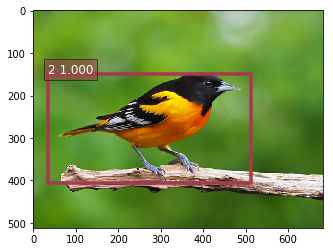

In [16]:
#net = gcv.model_zoo.get_model('ssd_300_vgg16_atrous_voc', pretrained_base=False)
#net.load_parameters('ssd_best.params')
net = gcv.model_zoo.get_model('yolo3_darknet53_coco', pretrained_base=False)
net.load_parameters('yolov3_best.params')
x, image = gcv.data.transforms.presets.ssd.load_test('bird.png', 512)
cid, score, bbox = net(x)
ax = utils.viz.plot_bbox(image, bbox[0], score[0]>.5, cid[0])
plt.show()